### Chargement du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df= pd.read_csv('AirPassengers.csv')
display(df)
df.info()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [2]:
airpass = pd.read_csv("AirPassengers.csv",index_col="Month",parse_dates=["Month"]) # ou True pour dire de transformer l'index en date
display(airpass)
airpass.info()
print (airpass.index)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)


### Affichage brut de la série temporelle

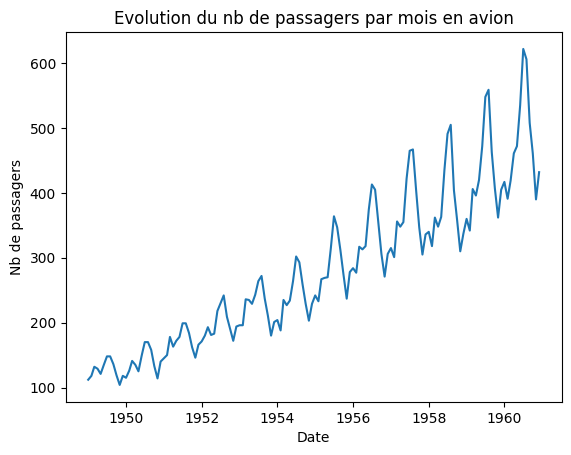

In [3]:
plt.plot(airpass)
plt.xlabel("Date")
plt.ylabel("Nb de passagers")
plt.title("Evolution du nb de passagers par mois en avion")
plt.show()

### Décomposition en tendance, saisonnalité et résidus

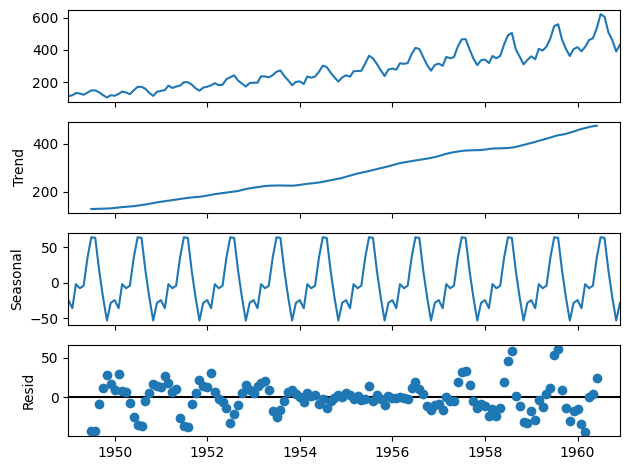

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_passengers = seasonal_decompose(airpass)
seasonal_passengers.plot()
plt.show()

# Modèle additif => pas terrible d'après les résidus

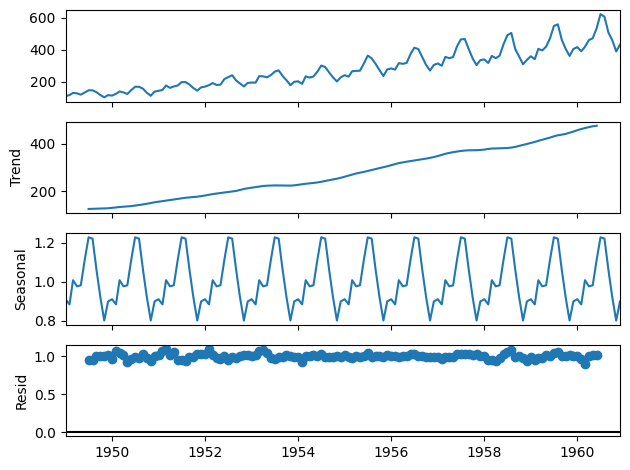

In [5]:
seasonal_passengers = seasonal_decompose(airpass,model='multiplicative')
seasonal_passengers.plot()
plt.show()

# Modèle multiplicatif => bien mieux

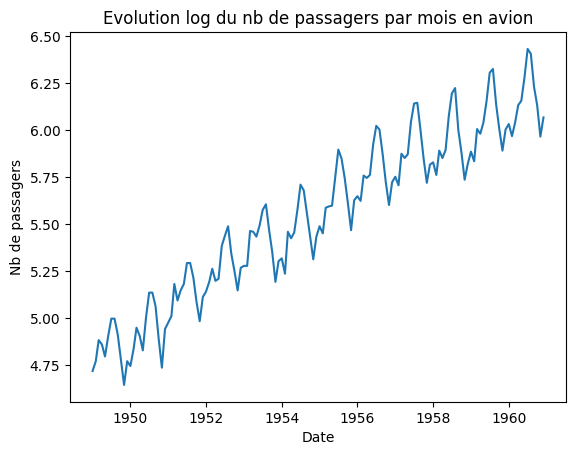

In [6]:
# Modèle multiplicatif => Transformation logarithmique de la série temporelle
airpasslog = np.log(airpass)

plt.plot(airpasslog)
plt.xlabel("Date")
plt.ylabel("Nb de passagers")
plt.title("Evolution log du nb de passagers par mois en avion")
plt.show()

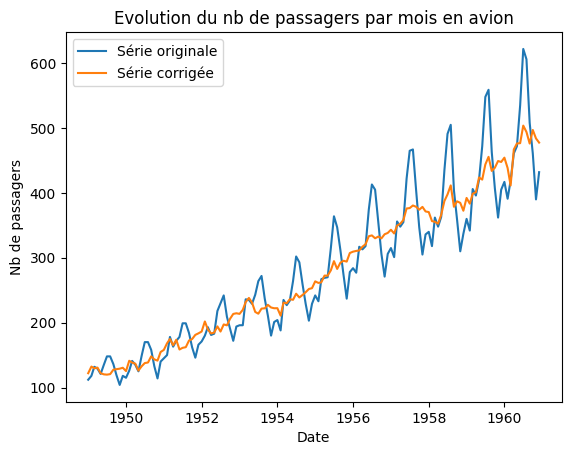

In [7]:
# On soustrait les coefficients saisonniers à la série airpasslog
airpasslog_cor = airpasslog['#Passengers'] - seasonal_decompose(airpasslog).seasonal

# On applique la fonction exponentielle pour retrouver la série originale
airpass_cor = np.exp(airpasslog_cor)

# On affiche la série
plt.plot(airpass, label='Série originale')
plt.plot(airpass_cor, label='Série corrigée') 

plt.xlabel("Date")
plt.ylabel("Nb de passagers")
plt.title("Evolution du nb de passagers par mois en avion")
plt.legend()
plt.show()

### Préparation des données pour la régression

In [ ]:
# 1ère variable explicative : Mois précédent
airpass['Passengers_lag1']= airpass['#Passengers'].shift(1)
display(airpass)

,#Passengers,Passengers_lag1
Month,,
1949-01-01,112,NaN
1949-02-01,118,112.0
1949-03-01,132,118.0
1949-04-01,129,132.0
1949-05-01,121,129.0
...,...,...
1960-08-01,606,622.0
1960-09-01,508,606.0
1960-10-01,461,508.0


In [10]:
# 2ème variable explicative : moyenne glissante des 3 mois précédents
airpass['Passengers_MA_3months']= airpass['Passengers_lag1'].rolling(3).mean()
display(airpass)

,#Passengers,Passengers_lag1,Passengers_MA_3months
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,112.0,NaN
1949-03-01,132,118.0,NaN
1949-04-01,129,132.0,120.666667
1949-05-01,121,129.0,126.333333
...,...,...,...
1960-08-01,606,622.0,543.000000
1960-09-01,508,606.0,587.666667
1960-10-01,461,508.0,578.666667


In [11]:
# Suppression des valeurs manquantes
airpass = airpass.dropna()
display(airpass)

,#Passengers,Passengers_lag1,Passengers_MA_3months
Month,,,
1949-04-01,129,132.0,120.666667
1949-05-01,121,129.0,126.333333
1949-06-01,135,121.0,127.333333
1949-07-01,148,135.0,128.333333
1949-08-01,148,148.0,134.666667
...,...,...,...
1960-08-01,606,622.0,543.000000
1960-09-01,508,606.0,587.666667
1960-10-01,461,508.0,578.666667


### Modèle prédictif de régression linéaire

In [12]:
# Séparation target / features
y = airpass['#Passengers']
X = airpass.drop('#Passengers',axis=1)

# Séparation train / test (test = les 2 dernières années)
X_train = X.iloc[:-24]
X_test = X.iloc[-24:]
y_train = y.iloc[:-24]
y_test = y.iloc[-24:]

In [13]:
# Entraînement régression linéaire
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

# Prédiction
from sklearn.metrics import root_mean_squared_error
pred_test = lr.predict(X_test)
print("RMSE :",root_mean_squared_error(y_test,pred_test))

RMSE : 50.094385915019416


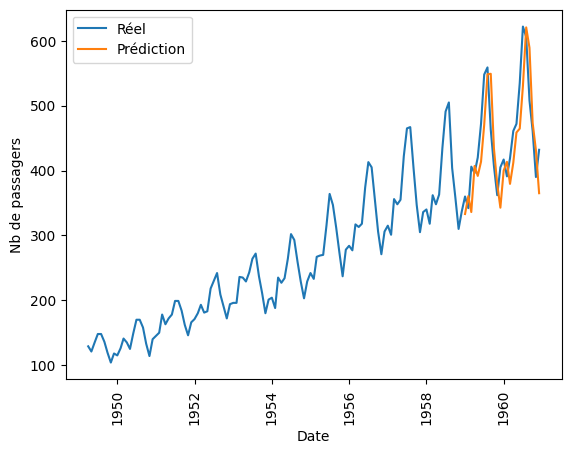

In [14]:
# Affichage réalité vs prédiction
plt.plot(y.index,y,label="Réel")
plt.plot(y_test.index,pred_test,label="Prédiction")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Nb de passagers")
plt.xticks(rotation=90)
plt.show()